In [1]:
import sys
import os
import warnings
import numpy as np
import pandas as pd
from pathlib import Path

In [2]:
# add RealSeries/realseries to sys path
sys.path.append('..')

In [3]:
from realseries.models.lstm_dynamic import LSTM_dynamic
from realseries.utils.evaluation import point_metrics, adjust_predicts
from realseries.utils.data import load_split_NASA, load_splitted_RNN, load_NAB
from realseries.utils.visualize import plot_anom,plot_mne
warnings.filterwarnings("ignore")
os.environ["CUDA_VISIBLE_DEVICES"] = '7'

In [4]:
# LSTM parameters
# --------------------------
dropout = 0.3
lstm_batch_size = 64
hidden_size = 128
num_layers = 2
lr = 1e-3
epochs = 60

In [5]:
# data parameters
# --------------------------
# time_window length of input data
l_s = 250 

# number of values to predict by input data
n_predictions =  12

In [6]:
# error parameters
# --------------------------
# number of values to evaluate in each batch in the prediction stage
batch_size = 100

# window_size to use in error calculation
window_size = 30

# determines window size used in EWMA smoothing (percentage of total values for channel)
smoothing_perc = 0.05

# number of values surrounding an error that are brought into the sequence (promotes grouping on nearby sequences
error_buffer = 50

# minimum percent decrease between max errors in anomalous sequences (used for pruning)
p = 0.13

In [8]:
# load data
# -----------------------
chan_id='A-4'
train_set, test_set= load_split_NASA(chan_id)
train_set.head(), test_set.head()

(         0    1    2    3    4    5    6    7    8    9   ...   16   17   18  \
 0  0.286792  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
 1  0.142956  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
 2  0.142956  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
 3  0.428656  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
 4  0.428656  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
 
     19   20   21   22   23   24   25  
 0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
 1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
 2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
 3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
 4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
 
 [5 rows x 26 columns],
          0    1    2    3    4    5    6    7    8    9   ...   16   17   18  \
 0  0.252336  1.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
 1  0.252336  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
 2 

In [9]:
# the last column is label and other columns are values
train_data, train_label = train_set.iloc[:, :-1], train_set.iloc[:, -1]
test_data, test_label = test_set.iloc[:, :-1], test_set.iloc[:, -1]

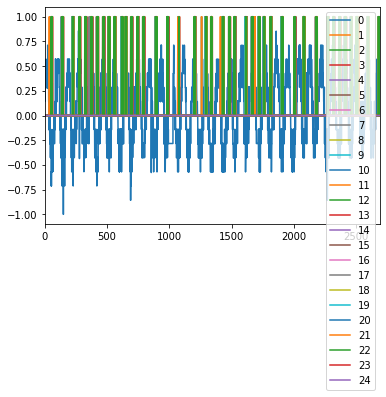

In [10]:
train_data.plot()

Creating RawArray with float64 data, n_channels=25, n_times=2690
    Range : 0 ... 2689 =      0.000 ...  2689.000 secs
Ready.


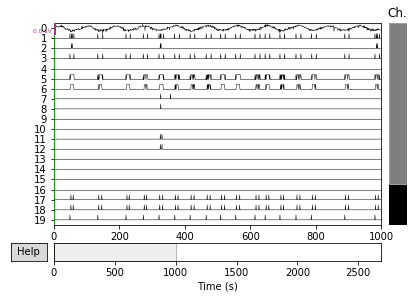

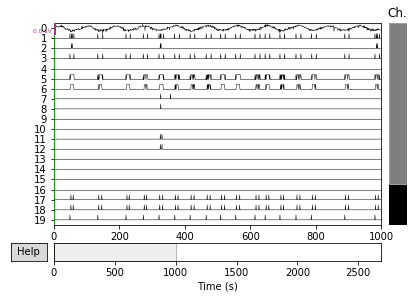

In [11]:
plot_mne(train_data,
        columns=None,
        duration=1000, 
        start=0,
        n_channels=20,
        scalings="auto")

In [12]:
# train stage
# --------------------------
# path to save model in Realseries/snapshot..... 
model_path = Path('',f'../snapshot/lstm_dym/{chan_id}')

# init the model class
lstm_dym = LSTM_dynamic(
    batch_size=batch_size,
    window_size=window_size,
    smoothing_perc=smoothing_perc,
    error_buffer=error_buffer,
    dropout=dropout,
    lstm_batch_size=lstm_batch_size,
    epochs=epochs,
    num_layers=num_layers,
    l_s=l_s,
    n_predictions=n_predictions,
    p=p,
    model_path=model_path,
    hidden_size=hidden_size,
    lr=lr)

In [13]:
# fit and test the model
lstm_dym.fit(train_data)

  2%|▏         | 1/60 [00:02<02:39,  2.71s/it]

train_loss: 0.11898 valid_loss: 0.10732
val_loss updated:(inf --> 0.107321).


  3%|▎         | 2/60 [00:03<02:01,  2.10s/it]

train_loss: 0.07636 valid_loss: 0.05545
val_loss updated:(0.107321 --> 0.055452).


  5%|▌         | 3/60 [00:04<01:38,  1.72s/it]

train_loss: 0.04115 valid_loss: 0.03054
val_loss updated:(0.055452 --> 0.030537).


  7%|▋         | 4/60 [00:05<01:20,  1.45s/it]

train_loss: 0.02823 valid_loss: 0.02521
val_loss updated:(0.030537 --> 0.025211).


  8%|▊         | 5/60 [00:05<01:09,  1.26s/it]

train_loss: 0.02588 valid_loss: 0.02500
val_loss updated:(0.025211 --> 0.025004).


 10%|█         | 6/60 [00:06<01:01,  1.14s/it]

train_loss: 0.02466 valid_loss: 0.02464
val_loss updated:(0.025004 --> 0.024642).


 12%|█▏        | 7/60 [00:07<00:55,  1.04s/it]

train_loss: 0.02434 valid_loss: 0.02445
val_loss updated:(0.024642 --> 0.024447).


 13%|█▎        | 8/60 [00:08<00:49,  1.04it/s]

train_loss: 0.02395 valid_loss: 0.02366
val_loss updated:(0.024447 --> 0.023661).


 15%|█▌        | 9/60 [00:09<00:46,  1.09it/s]

train_loss: 0.02364 valid_loss: 0.02314
val_loss updated:(0.023661 --> 0.023138).


 17%|█▋        | 10/60 [00:09<00:43,  1.15it/s]

train_loss: 0.02407 valid_loss: 0.02231
val_loss updated:(0.023138 --> 0.022314).


 18%|█▊        | 11/60 [00:10<00:40,  1.20it/s]

train_loss: 0.02352 valid_loss: 0.02266
EarlyStopping counter: 1 out of 10


 20%|██        | 12/60 [00:11<00:40,  1.19it/s]

train_loss: 0.02325 valid_loss: 0.02223
val_loss updated:(0.022314 --> 0.022232).


 22%|██▏       | 13/60 [00:12<00:38,  1.22it/s]

train_loss: 0.02369 valid_loss: 0.02192
val_loss updated:(0.022232 --> 0.021920).


 23%|██▎       | 14/60 [00:13<00:37,  1.22it/s]

train_loss: 0.02346 valid_loss: 0.02222
EarlyStopping counter: 1 out of 10


 25%|██▌       | 15/60 [00:13<00:36,  1.23it/s]

train_loss: 0.02322 valid_loss: 0.02370
EarlyStopping counter: 2 out of 10


 27%|██▋       | 16/60 [00:14<00:35,  1.25it/s]

train_loss: 0.02289 valid_loss: 0.02116
val_loss updated:(0.021920 --> 0.021157).


 28%|██▊       | 17/60 [00:15<00:33,  1.29it/s]

train_loss: 0.02274 valid_loss: 0.02216
EarlyStopping counter: 1 out of 10


 30%|███       | 18/60 [00:16<00:31,  1.33it/s]

train_loss: 0.02345 valid_loss: 0.02238
EarlyStopping counter: 2 out of 10


 32%|███▏      | 19/60 [00:16<00:31,  1.31it/s]

train_loss: 0.02267 valid_loss: 0.02174
EarlyStopping counter: 3 out of 10


 33%|███▎      | 20/60 [00:17<00:31,  1.26it/s]

train_loss: 0.02225 valid_loss: 0.02085
val_loss updated:(0.021157 --> 0.020852).
saving ../snapshot/lstm_dym/A-4/checkpoint20.pt


 35%|███▌      | 21/60 [00:18<00:30,  1.30it/s]

train_loss: 0.02230 valid_loss: 0.02116
EarlyStopping counter: 1 out of 10


 37%|███▋      | 22/60 [00:19<00:27,  1.38it/s]

train_loss: 0.02186 valid_loss: 0.02159
EarlyStopping counter: 2 out of 10


 38%|███▊      | 23/60 [00:19<00:28,  1.32it/s]

train_loss: 0.02257 valid_loss: 0.02220
EarlyStopping counter: 3 out of 10


 40%|████      | 24/60 [00:20<00:27,  1.31it/s]

train_loss: 0.02250 valid_loss: 0.02197
EarlyStopping counter: 4 out of 10


 42%|████▏     | 25/60 [00:21<00:26,  1.34it/s]

train_loss: 0.02176 valid_loss: 0.02134
EarlyStopping counter: 5 out of 10


 43%|████▎     | 26/60 [00:22<00:25,  1.35it/s]

train_loss: 0.02183 valid_loss: 0.02060
val_loss updated:(0.020852 --> 0.020596).


 45%|████▌     | 27/60 [00:22<00:25,  1.31it/s]

train_loss: 0.02231 valid_loss: 0.02192
EarlyStopping counter: 1 out of 10


 47%|████▋     | 28/60 [00:23<00:25,  1.26it/s]

train_loss: 0.02136 valid_loss: 0.02058
val_loss updated:(0.020596 --> 0.020575).


 48%|████▊     | 29/60 [00:24<00:24,  1.27it/s]

train_loss: 0.02135 valid_loss: 0.02239
EarlyStopping counter: 1 out of 10


 50%|█████     | 30/60 [00:25<00:23,  1.27it/s]

train_loss: 0.02101 valid_loss: 0.02091
EarlyStopping counter: 2 out of 10


 52%|█████▏    | 31/60 [00:26<00:22,  1.30it/s]

train_loss: 0.02090 valid_loss: 0.02037
val_loss updated:(0.020575 --> 0.020369).


 53%|█████▎    | 32/60 [00:26<00:22,  1.26it/s]

train_loss: 0.02138 valid_loss: 0.01983
val_loss updated:(0.020369 --> 0.019830).


 55%|█████▌    | 33/60 [00:27<00:20,  1.30it/s]

train_loss: 0.02129 valid_loss: 0.02076
EarlyStopping counter: 1 out of 10


 57%|█████▋    | 34/60 [00:28<00:20,  1.27it/s]

train_loss: 0.02139 valid_loss: 0.02107
EarlyStopping counter: 2 out of 10


 58%|█████▊    | 35/60 [00:29<00:19,  1.30it/s]

train_loss: 0.02084 valid_loss: 0.02046
EarlyStopping counter: 3 out of 10


 60%|██████    | 36/60 [00:29<00:18,  1.28it/s]

train_loss: 0.02057 valid_loss: 0.02051
EarlyStopping counter: 4 out of 10


 62%|██████▏   | 37/60 [00:30<00:18,  1.24it/s]

train_loss: 0.02025 valid_loss: 0.02069
EarlyStopping counter: 5 out of 10


 63%|██████▎   | 38/60 [00:31<00:17,  1.27it/s]

train_loss: 0.02039 valid_loss: 0.02198
EarlyStopping counter: 6 out of 10


 65%|██████▌   | 39/60 [00:32<00:16,  1.29it/s]

train_loss: 0.02007 valid_loss: 0.02040
EarlyStopping counter: 7 out of 10


 67%|██████▋   | 40/60 [00:33<00:15,  1.31it/s]

train_loss: 0.02023 valid_loss: 0.02072
EarlyStopping counter: 8 out of 10
saving ../snapshot/lstm_dym/A-4/checkpoint40.pt


 68%|██████▊   | 41/60 [00:33<00:14,  1.31it/s]

train_loss: 0.02030 valid_loss: 0.02015
EarlyStopping counter: 9 out of 10
train_loss: 0.02006 valid_loss: 0.02105
EarlyStopping counter: 10 out of 10
Early stopping
saving ../snapshot/lstm_dym/A-4/checkpoint.pt


In [14]:
anomaly_list, score_list = lstm_dym.detect(test_data)

loading ../snapshot/lstm_dym/A-4/checkpoint.pt
y_hat shape (7818,),y_test shape (7818, 12)
error_seq: [(4300, 4499)], error_seq_scores: [19.380197709933864]


In [16]:
# create anomaly score array for ploting and evaluation
pred_label = np.zeros(len(test_label))
score = np.zeros(len(test_label))
for (l, r), score_ in zip(anomaly_list, score_list):
    pred_label[l:r] = 1
    score[l:r] = score_

precision:0.5577889444433222, recall:0.9999999990990992, f1:0.716128985825185, tp:111, tn:7881, fp:88, fn:0


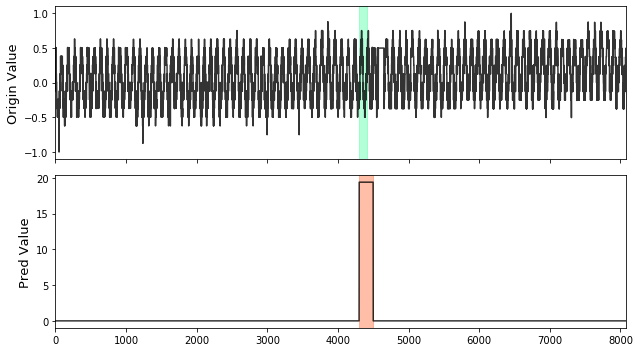

In [17]:
# visualization
plot_anom(
    test_set,
    pred_label,
    score)

# calc metrics
precision, recall, f1, tp, tn, fp, fn = point_metrics(pred_label,test_label)
print('precision:{}, recall:{}, f1:{}, tp:{}, tn:{}, fp:{}, fn:{}'.format(precision, recall, f1, tp, tn, fp, fn))

precision:0.5577889444433222, recall:0.9999999990990992, f1:0.716128985825185, tp:111, tn:7881, fp:88, fn:0


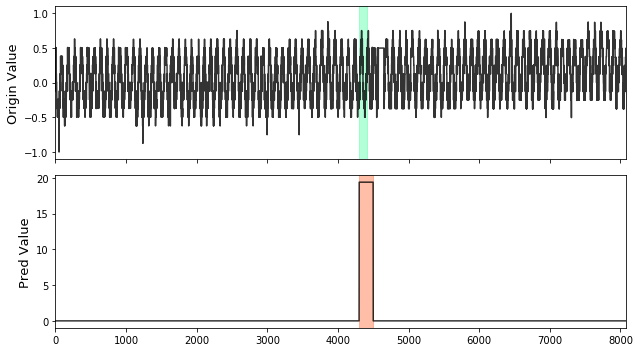

In [18]:
# adjust the pred_label for better visualization
adjust_pred_label = adjust_predicts(pred_label,test_label,delay=200)
plot_anom(
    test_set,
    adjust_pred_label,
    score)
precision, recall, f1, tp, tn, fp, fn = point_metrics(adjust_pred_label,test_label)
print('precision:{}, recall:{}, f1:{}, tp:{}, tn:{}, fp:{}, fn:{}'.format(precision, recall, f1, tp, tn, fp, fn))

In [19]:
# load and split data
# ----------------------------
dirname = 'realKnownCause'
filename = 'nyc_taxi.csv'

# the fraction of used for test
fraction=0.5
train_set, test_set = load_NAB(dirname, filename, fraction=fraction)

# preview data head
print(train_set.head())

load data from /mnt/mfs/zhangxianrui/code/RealSeries/examples/data/NAB_data/realKnownCause/nyc_taxi.csv
                       value  label
timestamp                          
2014-07-01 00:00:00  10844.0    0.0
2014-07-01 00:30:00   8127.0    0.0
2014-07-01 01:00:00   6210.0    0.0
2014-07-01 01:30:00   4656.0    0.0
2014-07-01 02:00:00   3820.0    0.0


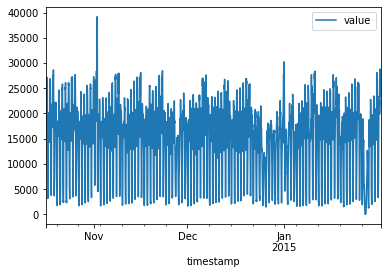

In [17]:
# the last column is label; other columns are values
# input must be 2-D array with shape (n_samplers,n_features)
train_data,train_label = train_set.iloc[:, :-1],train_set.iloc[:, -1]
test_data,test_label = test_set.iloc[:, :-1],test_set.iloc[:, -1]
test_data.plot()

In [18]:
from realseries.utils.preprocess import normalization
train_data,test_data = normalization(train_data),normalization(test_data)

In [19]:
# data parameters
# --------------------------
# time_window length of input data
l_s = 50 

# number of values to predict by input data
n_predictions =  5

# LSTM parameters
# --------------------------
dropout = 0.3
lstm_batch_size = 64
hidden_size = 128
num_layers = 2
lr = 1e-3
epochs = 40

In [20]:
# error parameters
# --------------------------
# number of values to evaluate in each batch in the prediction stage
batch_size = 100

# window_size to use in error calculation
window_size = 30

# determines window size used in EWMA smoothing (percentage of total values for channel)
smoothing_perc = 0.05

# number of values surrounding an error that are brought into the sequence (promotes grouping on nearby sequences
error_buffer = 20

# minimum percent decrease between max errors in anomalous sequences (used for pruning)
p = 0.13

In [21]:
# build the mdel
# --------------------------
# path to save model in Realseries/snapshot/..... 
model_path = Path('',f'../snapshot/lstm_dym/{filename[:-4]}')

# init the model class
lstm_dym = LSTM_dynamic(
    batch_size=batch_size,
    window_size=window_size,
    smoothing_perc=smoothing_perc,
    error_buffer=error_buffer,
    dropout=dropout,
    lstm_batch_size=lstm_batch_size,
    epochs=epochs,
    num_layers=num_layers,
    l_s=l_s,
    n_predictions=n_predictions,
    p=p,
    model_path=model_path,
    hidden_size=hidden_size,
    lr=lr)

In [22]:
# fit and test the model
lstm_dym.fit(train_data)


  2%|▎         | 1/40 [00:00<00:26,  1.50it/s]

train_loss: 0.09167 valid_loss: 0.05488
val_loss updated:(inf --> 0.054883).



  5%|▌         | 2/40 [00:01<00:26,  1.46it/s]

train_loss: 0.04679 valid_loss: 0.04464
val_loss updated:(0.054883 --> 0.044643).



  8%|▊         | 3/40 [00:02<00:24,  1.50it/s]

train_loss: 0.02954 valid_loss: 0.02520
val_loss updated:(0.044643 --> 0.025202).



 10%|█         | 4/40 [00:02<00:24,  1.47it/s]

train_loss: 0.02049 valid_loss: 0.01893
val_loss updated:(0.025202 --> 0.018931).



 12%|█▎        | 5/40 [00:03<00:23,  1.51it/s]

train_loss: 0.01716 valid_loss: 0.01363
val_loss updated:(0.018931 --> 0.013629).



 15%|█▌        | 6/40 [00:04<00:22,  1.49it/s]

train_loss: 0.01095 valid_loss: 0.00929
val_loss updated:(0.013629 --> 0.009286).



 18%|█▊        | 7/40 [00:04<00:23,  1.40it/s]

train_loss: 0.00875 valid_loss: 0.00747
val_loss updated:(0.009286 --> 0.007473).



 20%|██        | 8/40 [00:05<00:22,  1.40it/s]

train_loss: 0.00743 valid_loss: 0.00834
EarlyStopping counter: 1 out of 10



 22%|██▎       | 9/40 [00:06<00:22,  1.39it/s]

train_loss: 0.00767 valid_loss: 0.00662
val_loss updated:(0.007473 --> 0.006624).



 25%|██▌       | 10/40 [00:06<00:21,  1.41it/s]

train_loss: 0.00689 valid_loss: 0.00679
EarlyStopping counter: 1 out of 10



 28%|██▊       | 11/40 [00:07<00:20,  1.41it/s]

train_loss: 0.00707 valid_loss: 0.00682
EarlyStopping counter: 2 out of 10



 30%|███       | 12/40 [00:08<00:19,  1.41it/s]

train_loss: 0.00674 valid_loss: 0.00644
val_loss updated:(0.006624 --> 0.006445).



 32%|███▎      | 13/40 [00:09<00:19,  1.41it/s]

train_loss: 0.00612 valid_loss: 0.00593
val_loss updated:(0.006445 --> 0.005928).



 35%|███▌      | 14/40 [00:09<00:18,  1.43it/s]

train_loss: 0.00623 valid_loss: 0.00566
val_loss updated:(0.005928 --> 0.005656).



 38%|███▊      | 15/40 [00:10<00:17,  1.39it/s]

train_loss: 0.00574 valid_loss: 0.00541
val_loss updated:(0.005656 --> 0.005405).



 40%|████      | 16/40 [00:11<00:17,  1.40it/s]

train_loss: 0.00570 valid_loss: 0.00541
EarlyStopping counter: 1 out of 10



 42%|████▎     | 17/40 [00:11<00:16,  1.41it/s]

train_loss: 0.00580 valid_loss: 0.00551
EarlyStopping counter: 2 out of 10



 45%|████▌     | 18/40 [00:12<00:15,  1.41it/s]

train_loss: 0.00539 valid_loss: 0.00515
val_loss updated:(0.005405 --> 0.005148).



 48%|████▊     | 19/40 [00:13<00:14,  1.40it/s]

train_loss: 0.00501 valid_loss: 0.00476
val_loss updated:(0.005148 --> 0.004765).



 50%|█████     | 20/40 [00:14<00:15,  1.32it/s]

train_loss: 0.00478 valid_loss: 0.00488
EarlyStopping counter: 1 out of 10
saving ../snapshot/lstm_dym/nyc_taxi/checkpoint20.pt



 52%|█████▎    | 21/40 [00:14<00:13,  1.36it/s]

train_loss: 0.00447 valid_loss: 0.00406
val_loss updated:(0.004765 --> 0.004060).



 55%|█████▌    | 22/40 [00:15<00:13,  1.34it/s]

train_loss: 0.00423 valid_loss: 0.00342
val_loss updated:(0.004060 --> 0.003424).



 57%|█████▊    | 23/40 [00:16<00:12,  1.38it/s]

train_loss: 0.00387 valid_loss: 0.00353
EarlyStopping counter: 1 out of 10



 60%|██████    | 24/40 [00:17<00:11,  1.38it/s]

train_loss: 0.00416 valid_loss: 0.00417
EarlyStopping counter: 2 out of 10



 62%|██████▎   | 25/40 [00:17<00:10,  1.43it/s]

train_loss: 0.00362 valid_loss: 0.00318
val_loss updated:(0.003424 --> 0.003178).



 65%|██████▌   | 26/40 [00:18<00:10,  1.36it/s]

train_loss: 0.00330 valid_loss: 0.00307
val_loss updated:(0.003178 --> 0.003067).



 68%|██████▊   | 27/40 [00:19<00:09,  1.42it/s]

train_loss: 0.00334 valid_loss: 0.00348
EarlyStopping counter: 1 out of 10



 70%|███████   | 28/40 [00:19<00:08,  1.43it/s]

train_loss: 0.00363 valid_loss: 0.00333
EarlyStopping counter: 2 out of 10



 72%|███████▎  | 29/40 [00:20<00:07,  1.45it/s]

train_loss: 0.00331 valid_loss: 0.00297
val_loss updated:(0.003067 --> 0.002965).



 75%|███████▌  | 30/40 [00:21<00:06,  1.47it/s]

train_loss: 0.00316 valid_loss: 0.00288
val_loss updated:(0.002965 --> 0.002885).



 78%|███████▊  | 31/40 [00:21<00:06,  1.42it/s]

train_loss: 0.00299 valid_loss: 0.00337
EarlyStopping counter: 1 out of 10



 80%|████████  | 32/40 [00:22<00:05,  1.45it/s]

train_loss: 0.00312 valid_loss: 0.00289
EarlyStopping counter: 2 out of 10



 82%|████████▎ | 33/40 [00:23<00:04,  1.43it/s]

train_loss: 0.00278 valid_loss: 0.00245
val_loss updated:(0.002885 --> 0.002454).



 85%|████████▌ | 34/40 [00:24<00:04,  1.43it/s]

train_loss: 0.00279 valid_loss: 0.00248
EarlyStopping counter: 1 out of 10



 88%|████████▊ | 35/40 [00:24<00:03,  1.43it/s]

train_loss: 0.00271 valid_loss: 0.00296
EarlyStopping counter: 2 out of 10



 90%|█████████ | 36/40 [00:25<00:02,  1.43it/s]

train_loss: 0.00257 valid_loss: 0.00223
val_loss updated:(0.002454 --> 0.002232).



 92%|█████████▎| 37/40 [00:26<00:02,  1.44it/s]

train_loss: 0.00257 valid_loss: 0.00226
EarlyStopping counter: 1 out of 10



 95%|█████████▌| 38/40 [00:26<00:01,  1.46it/s]

train_loss: 0.00256 valid_loss: 0.00244
EarlyStopping counter: 2 out of 10



 98%|█████████▊| 39/40 [00:27<00:00,  1.47it/s]

train_loss: 0.00243 valid_loss: 0.00243
EarlyStopping counter: 3 out of 10



100%|██████████| 40/40 [00:28<00:00,  1.41it/s]

train_loss: 0.00246 valid_loss: 0.00242
EarlyStopping counter: 4 out of 10
saving ../snapshot/lstm_dym/nyc_taxi/checkpoint40.pt
saving ../snapshot/lstm_dym/nyc_taxi/checkpoint.pt


In [23]:
anomaly_list, score_list = lstm_dym.detect(test_data)

loading ../snapshot/lstm_dym/nyc_taxi/checkpoint.pt
y_hat shape (5105,),y_test shape (5105, 5)
error_seq: [(725, 800), (4863, 4988)], error_seq_scores: [73.87994868637398, 73.86750626999448]


In [24]:
# create anomaly score array for ploting and evaluation
pred_label = np.zeros(len(test_label))
score = np.zeros(len(test_label))
for (l, r), score_ in zip(anomaly_list, score_list):
    pred_label[l:r] = 1
    score[l:r] = score_

precision:0.9999999995000001, recall:0.19323671495717518, f1:0.3238866124801281, tp:200, tn:4125, fp:0, fn:835


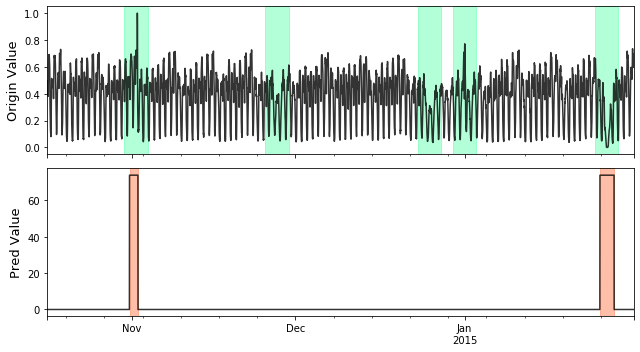

In [25]:
# visualization
plot_anom(
    test_set,
    pred_label,
    score)

# calc metrics
precision, recall, f1, tp, tn, fp, fn = point_metrics(pred_label,test_label)
print('precision:{}, recall:{}, f1:{}, tp:{}, tn:{}, fp:{}, fn:{}'.format(precision, recall, f1, tp, tn, fp, fn))

precision:0.9999999997584541, recall:0.3999999999613526, f1:0.5714285305333756, tp:414, tn:4125, fp:0, fn:621


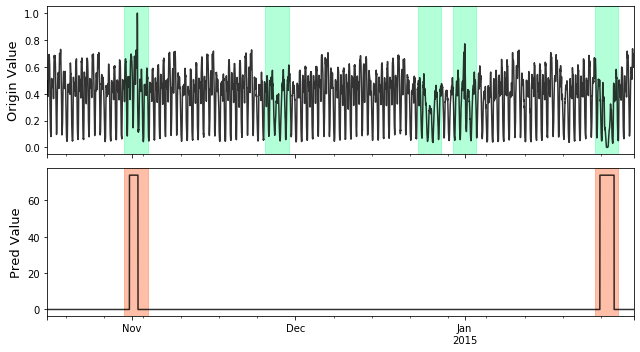

In [26]:
# adjust the pred_label for better visualization
adjust_pred_label = adjust_predicts(pred_label,test_label,delay=200)
plot_anom(
    test_set,
    adjust_pred_label,
    score)
precision, recall, f1, tp, tn, fp, fn = point_metrics(adjust_pred_label,test_label)
print('precision:{}, recall:{}, f1:{}, tp:{}, tn:{}, fp:{}, fn:{}'.format(precision, recall, f1, tp, tn, fp, fn))